In [57]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

#import F
from torch.nn import functional as F

In [58]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [59]:
image_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize([0.5], [0.5]),transforms.Lambda(lambda x : x.to(device))
])


In [60]:
# Creating training and testing datasets
train_dataset = MNIST(root='./MnistDataset', train=True, transform=image_transform, download=True)
validation_dataset = MNIST(root='./MnistDataset', train=False, transform=image_transform, download=True)

In [61]:
# Set up the dataloaders
from torch.utils.data import DataLoader
batch_size = 128

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationLoader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [62]:
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self, x_dimension, h_dimension1, h_dimension2, z_dimension):
        super(VariationalAutoEncoder, self).__init__()
        
        self.layer1 = nn.Linear(x_dimension, h_dimension1)
        self.layer2 = nn.Linear(h_dimension1, h_dimension2)
        self.layer31 = nn.Linear(h_dimension2, z_dimension)
        self.layer32 = nn.Linear(h_dimension2, z_dimension)
        self.layer4 = nn.Linear(z_dimension, h_dimension2)
        self.layer5 = nn.Linear(h_dimension2, h_dimension1)
        self.layer6 = nn.Linear(h_dimension1, x_dimension)
        
        # Layer 1, Layer 2 are for encoding, Layer 5,6 are for decoding
        # layers 31,32 are for mean and variance of the latent variable z
    
    def encoder(self, x):
        h = F.relu(self.layer1(x))
        h = F.relu(self.layer2(h))
        
        # return mean and log variance
        return self.layer31(h), self.layer32(h)
    
    # method to sample from encoder output
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    
    # define the decoder model
    def decoder(self, z):
        h = F.relu(self.layer4(z))
        h = F.relu(self.layer5(h))
        return torch.sigmoid(self.layer6(h))
    
    # define the forward pass
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var

In [63]:
# training batch
def trainBatch(data, model, optimiser, loss_function):
    model.train()
    data = data.to(device)
    optimiser.zero_grad()
    reconstructed_batch, mean, log_var = model(data)
    
    # losses
    loss, mse, KLdivergence = loss_function(reconstructed_batch, data, mean, log_var)
    loss.backward()
    optimiser.step()
    
    return loss, mse, KLdivergence, log_var.mean(), mean.mean()

# validation batch
@torch.no_grad()
def validateBatch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    reconstructed_batch, mean, log_var = model(data)
    
    # losses
    loss, mse, KLdivergence = loss_function(reconstructed_batch, data, mean, log_var)
    
    return loss, mse, KLdivergence, log_var.mean(), mean.mean()

In [64]:
def loss_function(reconstruced_x, x, mean, log_var):
    reconstruction = F.mse_loss(reconstruced_x, x.view(-1, 784), reduction='sum')
    
    KLdivergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return reconstruction + KLdivergence, reconstruction, KLdivergence

In [65]:
# Initialize the model
model = VariationalAutoEncoder(x_dimension=784, h_dimension1=512, h_dimension2=256, z_dimension=50).to(device)

# optimizer
optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)

EPOCH: 1.000  val_log_var: -0.056  val_mean: -0.004  val_kld: 162.455  train_recon: 93819.577  val_loss: 92715.590  train_loss: 94077.421  train_mean: 0.005  val_recon: 92553.136  train_log_var: 0.007  train_kld: 257.844  (4.92s - 1472.47s remaining)
EPOCH: 2.000  val_log_var: -0.061  val_mean: -0.003  val_kld: 181.276  train_recon: 92478.424  val_loss: 91588.883  train_loss: 92601.284  train_mean: -0.000  val_recon: 91407.607  train_log_var: -0.037  train_kld: 122.860  (9.79s - 1458.45s remaining)
EPOCH: 3.000  val_log_var: -0.101  val_mean: -0.003  val_kld: 313.246  train_recon: 92248.980  val_loss: 91335.282  train_loss: 92465.010  train_mean: -0.000  val_recon: 91022.036  train_log_var: -0.068  train_kld: 216.030  (14.74s - 1459.30s remaining)
EPOCH: 4.000  val_log_var: -0.144  val_mean: -0.003  val_kld: 477.005  train_recon: 91689.945  val_loss: 90910.430  train_loss: 92067.830  train_mean: -0.000  val_recon: 90433.425  train_log_var: -0.117  train_kld: 377.884  (19.63s - 1452.68s

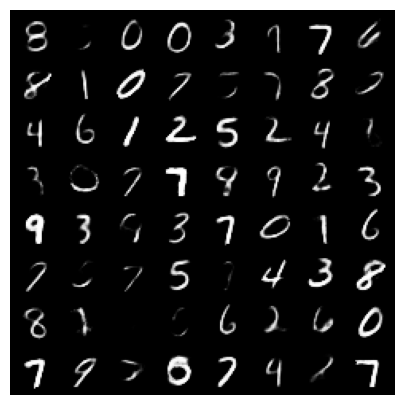

In [66]:
#import report
from torch_snippets import Report

#import make_grid
from torchvision.utils import make_grid

# import show
from torch_snippets import show
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trainLoader)
    for batchIndex , (image, label) in enumerate(trainLoader):
        loss, recon, KL, log_var, mean = trainBatch(image, model, optimiser, loss_function)
        
        pos = epoch + (batchIndex + 1)/N
        log.record(pos, train_loss = loss, train_kld=KL, train_recon=recon,train_log_var=log_var, train_mean=mean, end='\r')
    
    N = len(validationLoader)
    for batchIndex, (image, label) in enumerate(validationLoader):
        loss, recon, KL, log_var, mean = validateBatch(image, model, loss_function)
        
        pos = epoch + (batchIndex + 1)/N
        log.record(pos, val_loss = loss, val_kld=KL, val_recon=recon,val_log_var=log_var, val_mean=mean, end='\r') 
        
    log.report_avgs(epoch+1)
with torch.no_grad():
    z = torch.randn(64, 50).to(device)
    sample = model.decoder(z).to(device)
    images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
    show(images)


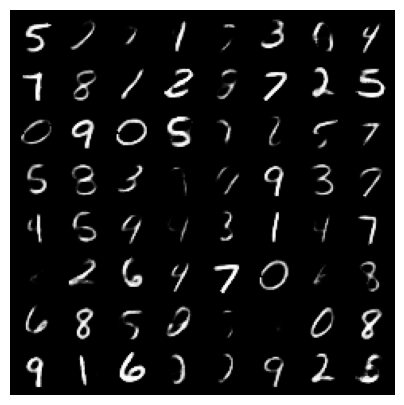

In [74]:
with torch.no_grad():
    z = torch.randn(64, 50).to(device)
    sample = model.decoder(z).to(device)
    images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
    show(images)

100%|██████████| 401/401 [00:03<00:00, 112.20it/s]


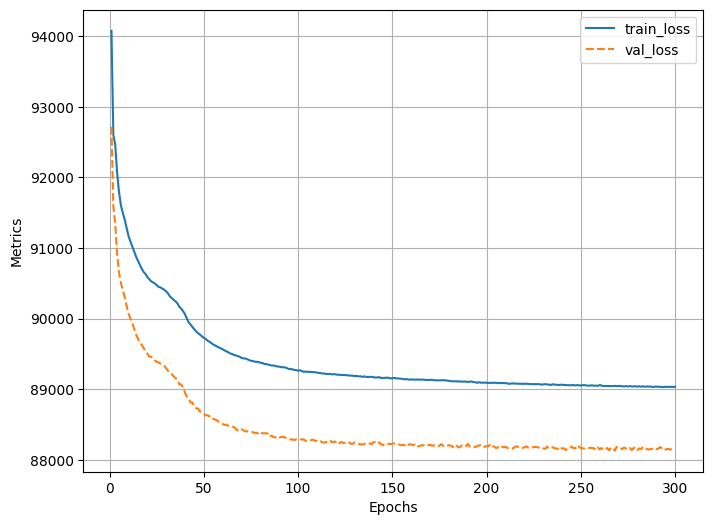

In [68]:
log.plot_epochs(['train_loss', 'val_loss'])